What to do here?

- Highlight the different data types.
- Pairwise registration
- Groupwise registration
- integration
- export
- Note different functionalities in notebook
- Function for making fake sections.
- Show plotting analysis from paper.
- Finish up documentation/ API docs?
- Minor improvements (e.g. return object from greedyfhist)

- Add so data. Show register_to_reference_image function.

In [1]:
import glob
import os
from os.path import exists, join
from typing import Optional

import pandas, pandas as pd
import numpy, numpy as np

import matplotlib.pyplot as plt

from greedyfhist.registration import GreedyFHist
from greedyfhist.options import RegistrationOptions
from miit.utils.metrics import compute_tre
from miit.registerers import GreedyFHistExt
from miit.spatial_data.section import groupwise_registration

from helper_functions import load_sections, load_section, plot_sections, plot_registration_summary

Abbreviations:

- HES = Hematoxylin-Erythrosine-Saffron
- HE = Hematoxylin-Eosin
- MTS = Masson's Trichrome Staining
- IHC = Immunohistochemistry

## Loading Data and MIIT datatypes

In this section, we load data and introduce the different data types that MIIT uses.

Dataset description:
- 9 serial histology sections with the following stains: (HES, HE, HES, HES, HES, MTS, IHC, IHC, HES)
- Each serial section contains: 
  - landmarks with matching labels across all sections.
  - semi-manually generated tissue masks 
- Section 2 contain spatial transcriptomics data and additional histology classifications.
- Sections 6 and 7 contain imzml data that were generated with MALDI-MSI.


MIIT datatypes:

In order to manage the variety of different datatypes, MIIT uses wrapper classes that help with spatial transformations and registration operations. MIIT's wrapper classes can be devided into `basetypes` and more advanved `spatial-omics-types`. Currently, MIIT offers the following `baseclasses`:
`Image`, `Annotation`, `Pointset`, `GeoJSONData`, `OMETIFFImage`, `OMETIFFAnnotation`. And the following `so_classes`: `Visium` and `Imzml`. MIIT also has a composited class `Section` that can be used to compound multiple types of spatial data in the same image space.
In this tutorial only `Image`, `Annotation`, `Pointset`, `Visium` and `Imzml` are used.

`Image` is the default type applicable for most image types. 

`Annotation` is the data types equipped for dealing with annotation data. Data can either be 2 or 3 dimensional and uses nearest neighbor interpolation for image transformations.

`Pointset` is used for tabular data. Internally, pointset data is stored as a pandas DataFrame. Each datapoint can be associated with additional properties (i.e. columns in the DataFrame).

`Visium`:

`Imzml`:

In [2]:
section_directory = '../../../../Documents/miit_test_data/test_data_publication/'

In [3]:
os.listdir(section_directory)

['7', '9', '11', '8', '2', '10', '1', '6', '3']

In [4]:
sections = load_sections(section_directory)

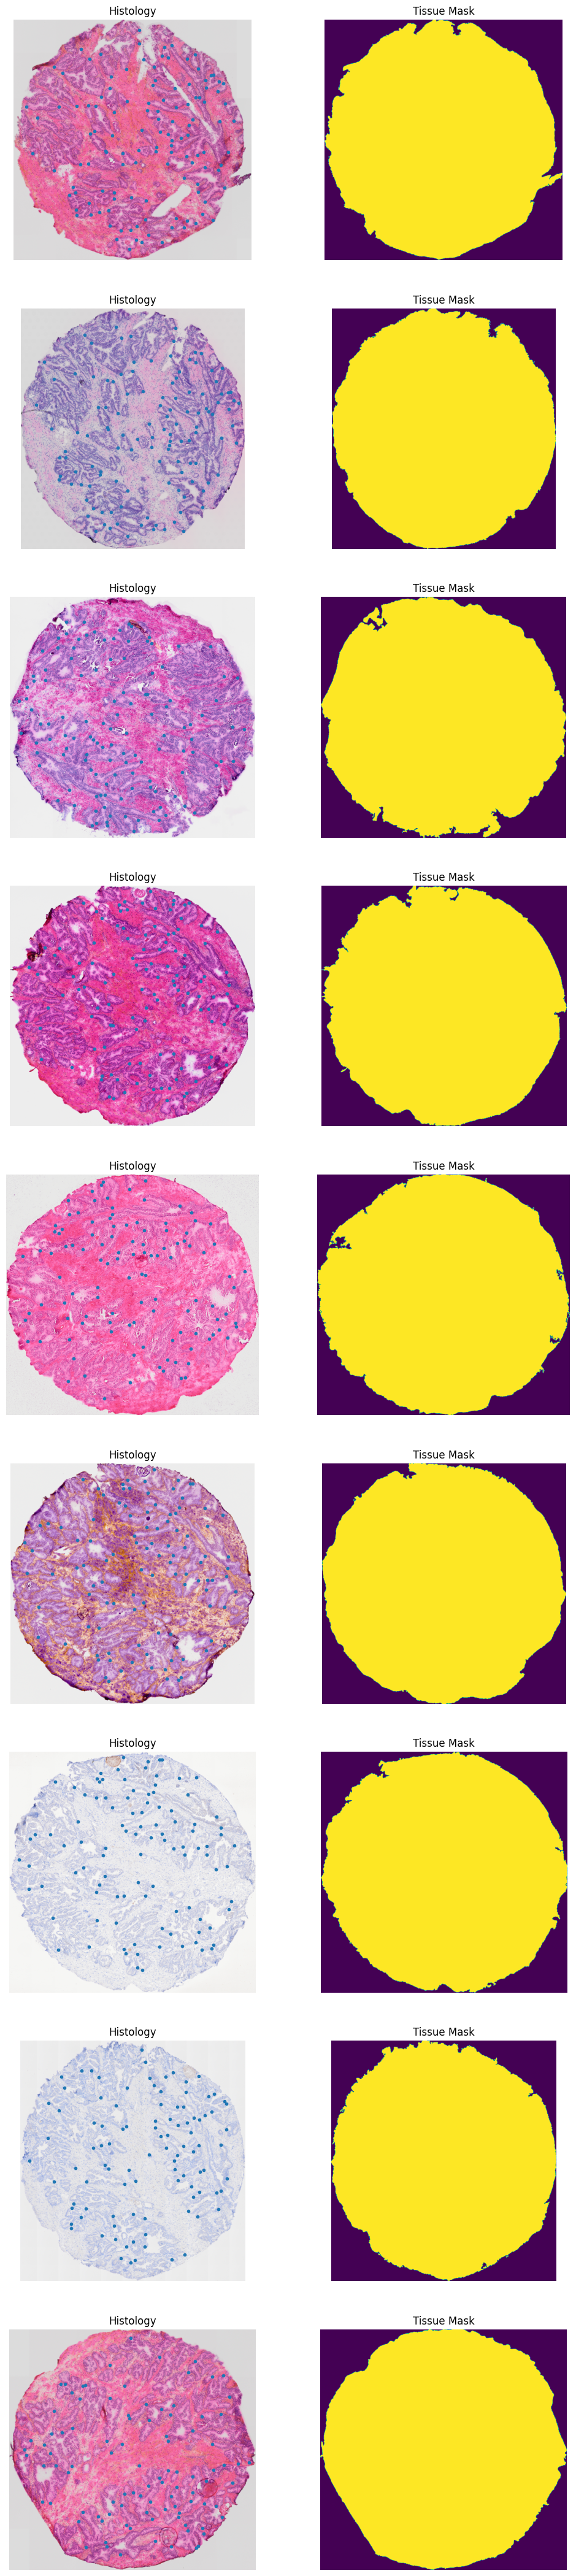

In [5]:
# Here we plot each histology image along with tissue masks and landmarks.
plot_sections(sections)

In [ ]:
section_list = list(sections.values())
len(section_list)

## Registration

The next section deals with the topic of registration. MIIT comes with a variety of registration algorithms for different purposes, but for the registration of serial sections we use the custom developed GreedyFHist algorithm (githum.com/mwess/greedyfhist). 

GreedyFHist can be used as a standalone tool or within MIIT. We will show examples for both applications.

### Registration - GreedyFHist standalone

In [12]:
# warped_sections = []

# options = RegistrationOptions()
# options.affine_registration_options.n_threads = 8
# options.nonrigid_registration_options.n_threads = 8
    
# registerer = GreedyFHist(path_to_greedy='mwess89/greedy:1.3.0-alpha', use_docker_container=True)

# for i in range(len(section_list)-1):
#     print(i)
#     moving_section = section_list[i]
#     fixed_section = section_list[i+1]
#     moving_image = moving_section.reference_image.data
#     fixed_image = fixed_section.reference_image.data

#     moving_img_mask = moving_section.get_annotations_by_names('tissue_mask').data
#     fixed_img_mask = fixed_section.get_annotations_by_names('tissue_mask').data

#     moving_lms = moving_section.get_annotations_by_names('landmarks').data
#     fixed_lms = fixed_section.get_annotations_by_names('landmarks').data



#     registration_result = registerer.register(
#         moving_img=moving_image,
#         fixed_img=fixed_image,
#         options=options
#     )

#     warped_image = registerer.transform_image(moving_image, registration_result.registration.forward_transform)
#     warped_lms = registerer.transform_pointset(moving_lms[['x', 'y']].to_numpy(), registration_result.registration.backward_transform)
#     warped_lms = pd.DataFrame(warped_lms, columns=['x', 'y'])
#     warped_lms['label'] = moving_lms['label'].copy()
#     warped_sections.append(((moving_image, moving_lms), (fixed_image, fixed_lms), (warped_image, warped_lms)))

In [13]:
# [compute_tre(x[1][1], x[2][1], x[2][0].shape) for x in warped_sections]

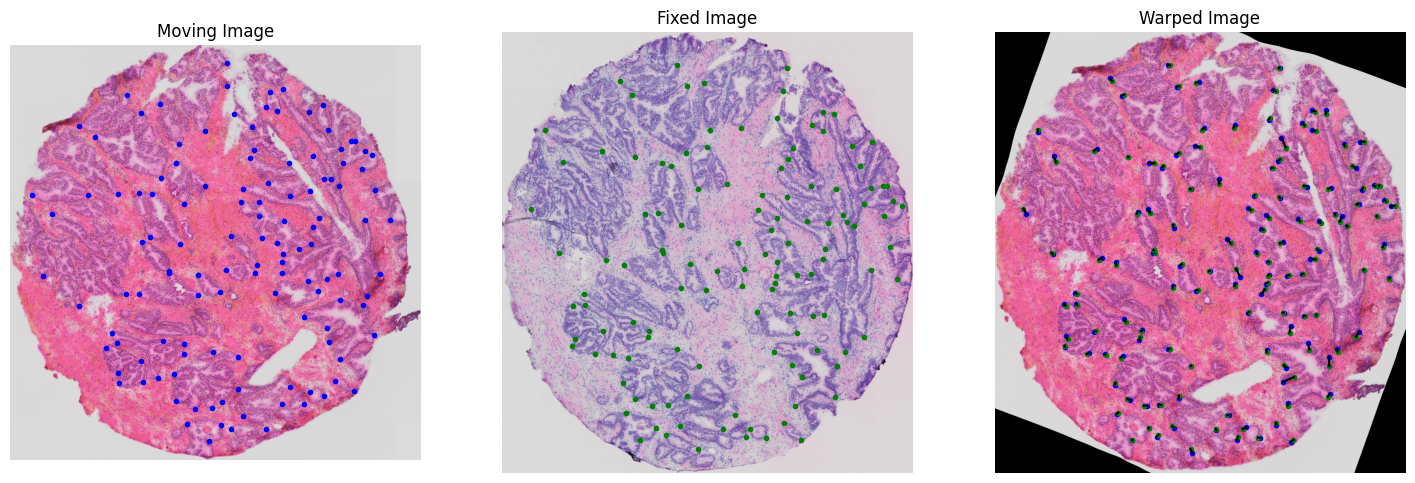

In [20]:
(moving_image, moving_lms), (fixed_image, fixed_lms), (warped_image, warped_lms) = warped_sections[0]
plot_registration_summary(
    moving_image,
    fixed_image,
    warped_image,
    moving_lms,
    fixed_lms,
    warped_lms,
    plot_lm_distance=True
)

In [51]:
moving_section = section_list[0]
fixed_section = section_list[1]

use_manual_tissue_masks = False

moving_image = moving_section.reference_image.data
fixed_image = fixed_section.reference_image.data

if use_manual_tissue_masks:
    moving_img_mask = moving_section.get_annotations_by_names('tissue_mask').data
    fixed_img_mask = fixed_section.get_annotations_by_names('tissue_mask').data
else:
    moving_img_mask = None
    fixed_img_mask = None

moving_lms = moving_section.get_annotations_by_names('landmarks').data
fixed_lms = fixed_section.get_annotations_by_names('landmarks').data

options = RegistrationOptions()
# We achieved the fastes registration when setting n_threads to 8. 
options.affine_registration_options.n_threads = 8
options.nonrigid_registration_options.n_threads = 8

GreedyFHist relies internally on the greedy tool. GreedyFHist can work with greedy either as an installed commandline application or as a docker executable. 

When greedy is installed as a commandline application, GreedyFHist needs the path to greedy. If greedy is on the PATH variable, no path needs to be provided. If greedy is used as a docker container executable, set path_to_greedy as the image name and set use_docker_container to True.

Note: If MIIT, GreedyFHist and greedy are all in a docker environment, path_to_greedy can be treated normally.

In [14]:
# Comment out the applicable initialization.

# When using greedy as a commandline application. (We assume that greedy is on PATH.)
# registerer = GreedyFHist()

# When using greedy through a docker container executable.
registerer = GreedyFHist(path_to_greedy='mwess89/greedy:1.3.0-alpha', use_docker_container=True)



In [52]:
registration_result = registerer.register(
    moving_img=moving_image,
    fixed_img=fixed_image,
    options=options
)

In [53]:
# We can use the computed registration_result to warp images to the fixed image space.
warped_image = registerer.transform_image(moving_image, registration_result.registration.forward_transform)
warped_lms = registerer.transform_pointset(moving_lms[['x', 'y']].to_numpy(), registration_result.registration.backward_transform)
warped_lms = pd.DataFrame(warped_lms, columns=['x', 'y'])
warped_lms['label'] = moving_lms['label'].copy()

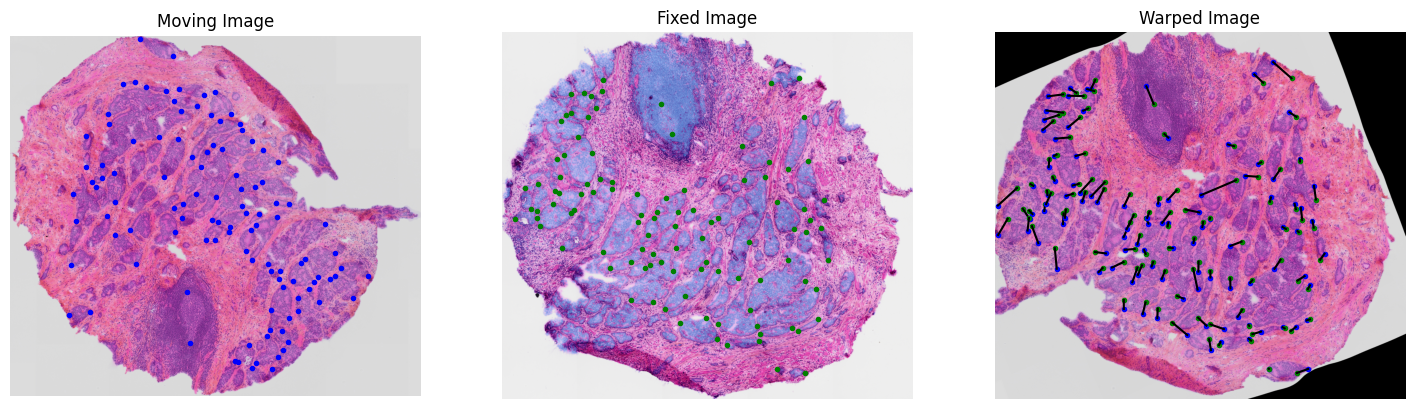

In [54]:
plot_registration_summary(moving_image,
                          fixed_image,
                          warped_image,
                          moving_lms,
                          fixed_lms,
                          warped_lms,
                          plot_lm_distance=True)

## Registration - Using MIIT

We could see in the last section, that warping one image and one set of landmarks already requires a few lines. With more data types this can be become increasingly cumbersome to keep track of. Therefor, we added wrapper classes for registration algorithms to MIIT, with the goal of easing the complexity of handling multiple data types. 

In [15]:
# GreedyFHists wrapper class 'GreedyFHistExt' can be initialized with the same arguments as GreefyFHist.
gfh_ext = GreedyFHistExt.init_registerer(path_to_greedy='mwess89/greedy:1.3.0-alpha',
                                         use_docker_container=True)

In [12]:
# GreedyFHistExt can be called very similarly to GreedyFHist.

moving_section = section_list[0]
fixed_section = section_list[1]

options = RegistrationOptions()
options.affine_registration_options.n_threads = 8
options.nonrigid_registration_options.n_threads = 8

registration_result = gfh_ext.register_images(moving_img=moving_section.reference_image.data,
                                              fixed_img=fixed_section.reference_image.data,
                                              options=options)

In [13]:
# After successful registration, we only need to pass, the registration_result and the associated
# registerer to the moving section and all data within the section is transformed to the fixed image space.
warped_section = moving_section.apply_transform(gfh_ext, registration_result)

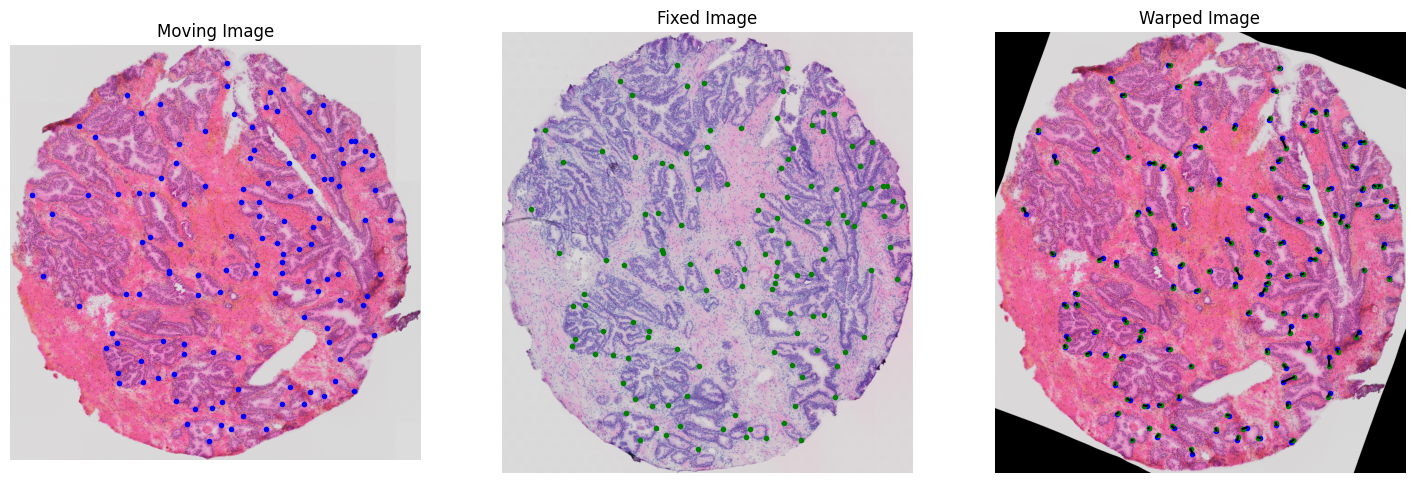

In [17]:
plot_registration_summary(
    moving_section.reference_image.data,
    fixed_section.reference_image.data,
    warped_section.reference_image.data,
    moving_section.get_annotations_by_names('landmarks').data,
    fixed_section.get_annotations_by_names('landmarks').data,
    warped_section.get_annotations_by_names('landmarks').data,
    plot_lm_distance=True
)

## Registration - Groupwise registration

GreedyFHist has a groupwise registration option that registers multiple images at once. We show here on how to use it in MIIT. 

At this moment, no other groupwise registration methods have been implented into MIIT.

In [9]:
options = RegistrationOptions()
options.affine_registration_options.n_threads = 8
options.nonrigid_registration_options.n_threads = 8

# We invert the list, because the last section in the list is by convention the fixed section
# and in this example, we want section[1] to be the fixed section.
section_list_ = [section_list[1], section_list[3], section_list[4]][::-1]

warped_sections, transforms = groupwise_registration(section_list_, gfh_ext, options=options)

Text(0.5, 1.0, 'Fixed Image')

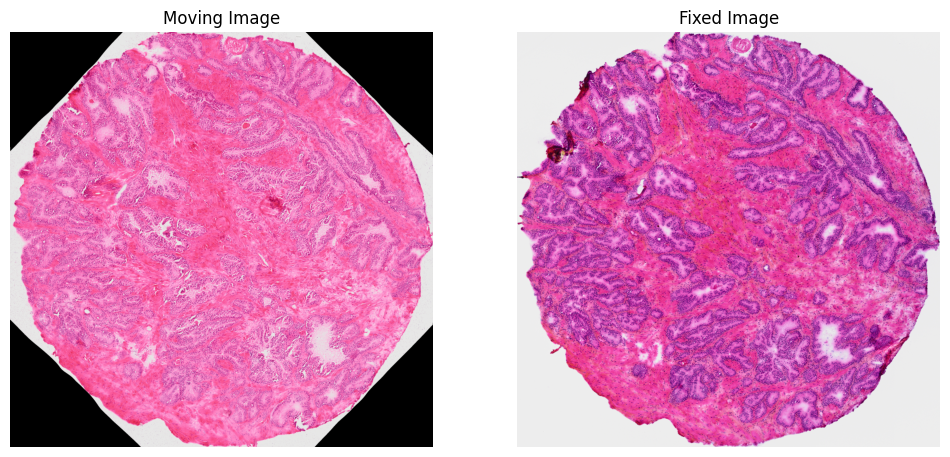

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(6* 2, 6 *1))
for ax in axs:
    ax.axis('off')
axs[0].imshow(warped_sections[0].reference_image.data)
axs[0].set_title('Moving Image')
axs[1].imshow(warped_sections[1].reference_image.data)
axs[1].set_title('Fixed Image')

## Integration

# Export

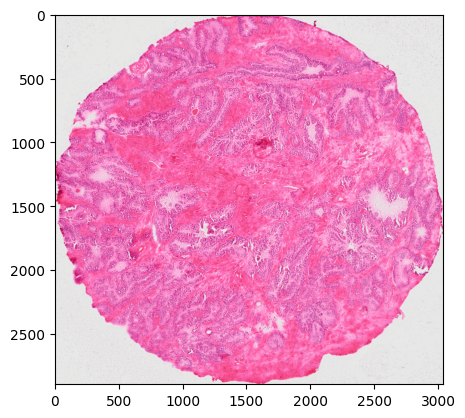

In [10]:
plt.imshow(section_list[4].reference_image.data)

In [13]:
import subprocess
import shlex

In [10]:
# cmd = '/bin/bash -i -c greedy -d 2 -i tmp/0/affine_fixed_preprocessing/preprocessed/new_small_image.nii.gz tmp/0/affine_moving_preprocessing/preprocessed/new_small_image.nii.gz -o tmp/0/output/registrations/0/metrics/small_resolution/small_affine.mat -m ncc 10x10 -n 100x50x10 -threads 8 -dof 12 -search 10000 180 106 -gm-trim 10x10 -a -ia tmp/0/Affine_init.mat'
# cmd = 'docker run mwess89/greedy:1.3.0-alpha -d 2 -i tmp/0/affine_fixed_preprocessing/preprocessed/new_small_image.nii.gz tmp/0/affine_moving_preprocessing/preprocessed/new_small_image.nii.gz -o tmp/0/output/registrations/0/metrics/small_resolution/small_affine.mat -m ncc 10x10 -n 100x50x10 -threads 8 -dof 12 -search 10000 180 106 -gm-trim 10x10 -a -ia tmp/0/Affine_init.mat'
# cmd = 'docker run mwess89/greedy:1.3.0-alpha -d 2 -i tmp/0/affine_fixed_preprocessing/preprocessed/new_small_image.nii.gz tmp/0/affine_moving_preprocessing/preprocessed/new_small_image.nii.gz -o tmp/0/output/registrations/0/metrics/small_resolution/small_affine.mat -m ncc 10x10 -n 100x50x10 -threads 8 -dof 12 -search 10000 180 106 -gm-trim 10x10 -a -ia tmp/0/Affine_init.mat'
# cmd = 'docker run -v $(pwd)/tmp/0:/tmp/0 mwess89/greedy:1.3.0-alpha -d 2 -i tmp/0/affine_fixed_preprocessing/preprocessed/new_small_image.nii.gz tmp/0/affine_moving_preprocessing/preprocessed/new_small_image.nii.gz -o tmp/0/output/registrations/0/metrics/small_resolution/small_affine.mat -m ncc 10x10 -n 100x50x10 -threads 8 -dof 12 -search 10000 180 106 -gm-trim 10x10 -a -ia tmp/0/Affine_init.mat'
cmd = 'docker run -v $(pwd)//home/maxi/applications/miit/examples/notebooks/tmp/0:/tmp/0 mwess89/greedy:1.3.0-alpha -d 2 -i tmp/0/affine_fixed_preprocessing/preprocessed/new_small_image.nii.gz tmp/0/affine_moving_preprocessing/preprocessed/new_small_image.nii.gz -o tmp/0/output/registrations/0/metrics/small_resolution/small_affine.mat -m ncc 10x10 -n 100x50x10 -threads 8 -dof 12 -search 10000 180 106 -gm-trim 10x10 -a -ia tmp/0/Affine_init.mat'

In [16]:
ret = subprocess.run(shlex.split(cmd), shell=True)
ret


Usage:  docker [OPTIONS] COMMAND

A self-sufficient runtime for containers

Options:
      --config string      Location of client config files (default
                           "/home/maxi/.docker")
  -c, --context string     Name of the context to use to connect to the
                           daemon (overrides DOCKER_HOST env var and
                           default context set with "docker context use")
  -D, --debug              Enable debug mode
  -H, --host list          Daemon socket(s) to connect to
  -l, --log-level string   Set the logging level
                           ("debug"|"info"|"warn"|"error"|"fatal")
                           (default "info")
      --tls                Use TLS; implied by --tlsverify
      --tlscacert string   Trust certs signed only by this CA (default
                           "/home/maxi/.docker/ca.pem")
      --tlscert string     Path to TLS certificate file (default
                           "/home/maxi/.docker/cert.pem")
      --tl

CompletedProcess(args=['docker', 'run', '-v', '$(pwd)/tmp/0:/tmp/0', 'mwess89/greedy:1.3.0-alpha', '-d', '2', '-i', 'tmp/0/affine_fixed_preprocessing/preprocessed/new_small_image.nii.gz', 'tmp/0/affine_moving_preprocessing/preprocessed/new_small_image.nii.gz', '-o', 'tmp/0/output/registrations/0/metrics/small_resolution/small_affine.mat', '-m', 'ncc', '10x10', '-n', '100x50x10', '-threads', '8', '-dof', '12', '-search', '10000', '180', '106', '-gm-trim', '10x10', '-a', '-ia', 'tmp/0/Affine_init.mat'], returncode=0)

In [17]:
# subprocess.call(['/bin/bash', '-i', '-c', 'greedy', '-d', '2'])
subprocess.call(['greedy', '-d', '2'], shell=True)

-d: 1: greedy: not found


127

In [21]:
subprocess.run(['docker', 'run', 'mwess89/greedy:1.3.0-alpha', '-d', '2'])

Executing with the default number of threads: 8


ABORTING PROGRAM DUE TO RUNTIME EXCEPTION -- No image inputs have been specified


CompletedProcess(args=['docker', 'run', 'mwess89/greedy:1.3.0-alpha', '-d', '2'], returncode=255)

In [29]:
import SimpleITK as sitk
img = sitk.GetArrayFromImage(sitk.ReadImage('tmp/0/affine_fixed_preprocessing/preprocessed/new_small_image.nii.gz'))
img

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [28]:
shlex.split(cmd)

['docker',
 'run',
 'mwess89/greedy:1.3.0-alpha',
 '-d',
 '2',
 '-i',
 'tmp/0/affine_fixed_preprocessing/preprocessed/new_small_image.nii.gz',
 'tmp/0/affine_moving_preprocessing/preprocessed/new_small_image.nii.gz',
 '-o',
 'tmp/0/output/registrations/0/metrics/small_resolution/small_affine.mat',
 '-m',
 'ncc',
 '10x10',
 '-n',
 '100x50x10',
 '-threads',
 '8',
 '-dof',
 '12',
 '-search',
 '10000',
 '180',
 '106',
 '-gm-trim',
 '10x10',
 '-a',
 '-ia',
 'tmp/0/Affine_init.mat']

In [31]:
print(cmd)

docker run mwess89/greedy:1.3.0-alpha -d 2 -i tmp/0/affine_fixed_preprocessing/preprocessed/new_small_image.nii.gz tmp/0/affine_moving_preprocessing/preprocessed/new_small_image.nii.gz -o tmp/0/output/registrations/0/metrics/small_resolution/small_affine.mat -m ncc 10x10 -n 100x50x10 -threads 8 -dof 12 -search 10000 180 106 -gm-trim 10x10 -a -ia tmp/0/Affine_init.mat
